# 📊 Notebook Overview

This notebook presents an analysis of the dataset using two different modeling approaches:
**Linear Regression** and **Generalized Linear Models (GLM)**.

The goal is to explore the data, prepare it carefully, and evaluate how each model captures
the relationship between the predictors and the target variable. By comparing both approaches,
we can better understand their strengths, assumptions, and practical differences.

The data used in this project comes from a public dataset published on Kaggle.
It contains product information from an Indian supermarket chain called **Big Basket**.

The dataset includes the following features:

- **product** (string): name of the product. One missing value is present.
- **category** (string): category to which the product belongs (11 categories).
- **sub_category** (string): nested product subcategory (90 sub-categories).
- **brand** (string): brand of the product (2313 unique brands). One missing value is present.
- **sale_price** (numerical): sale price of the product.
- **market_price** (numerical): market price of the product.
- **type** (string): product type related to the category (426 unique types).
- **rating** (numerical): customer rating from 1 to 5. This is the target variable and contains some missing values.
- **description** (string): product description. Almost one description per product, with many missing values.

The objective of this project is to predict the **product rating** based on the remaining features.


## 📦 Importing Data

In [104]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

# statsmodels imports
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Encoding
from category_encoders import TargetEncoder as SafeTargetEncoder

# Models
from sklearn.linear_model import LinearRegression

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [105]:
# Load dataset
df = pd.read_csv('BigBasket Products.csv', sep=',')

Some observations in the dataset do not contain the target variable (`rating`).
For this reason, the data is split into two separate datasets:
one containing ratings (used for training and evaluation),
and another without ratings, which can only be used for prediction.

In [106]:
# Separate data with missing ratings for later prediction
test_no_target = df[df['rating'].isnull()].copy()
df = df[df['rating'].notnull()].copy()

print("="*60)
print("DATA SEPARATION")
print("="*60)
print(f"Dataset with rating (df): {df.shape[0]} rows")
print(f"Dataset without rating (test_no_target): {test_no_target.shape[0]} rows")
print(f"Total: {df.shape[0] + test_no_target.shape[0]} rows")

DATA SEPARATION
Dataset with rating (df): 18929 rows
Dataset without rating (test_no_target): 8626 rows
Total: 27555 rows


The dataset containing the target variable is split into training and testing sets.
A test size of 30% is used to evaluate model performance on unseen data.

In [107]:
# Split data into training (70%) and testing (30%)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)
print(f"Training set: {df_train.shape[0]} rows ({100*df_train.shape[0]/(df_train.shape[0]+df_test.shape[0]):.1f}%)")
print(f"Test set: {df_test.shape[0]} rows ({100*df_test.shape[0]/(df_train.shape[0]+df_test.shape[0]):.1f}%)")
print(f"Total: {df_train.shape[0] + df_test.shape[0]} rows")

TRAIN-TEST SPLIT
Training set: 13250 rows (70.0%)
Test set: 5679 rows (30.0%)
Total: 18929 rows


The training and testing sets are further divided into input features (X)
and the target variable (y).

In [108]:
X_train = df_train.drop('rating', axis=1)
y_train = df_train['rating']
X_test = df_test.drop('rating', axis=1)
y_test = df_test['rating']

## 📈 EDA

We first inspect the size and structure of the training dataset to understand
the number of observations, data types, and basic summary statistics.

In [109]:
print(len(df_train))
print("-"*90)
df_train.info()
print("-"*90)
df_train.describe()

13250
------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 13250 entries, 24019 to 23000
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         13250 non-null  int64  
 1   product       13249 non-null  object 
 2   category      13250 non-null  object 
 3   sub_category  13250 non-null  object 
 4   brand         13250 non-null  object 
 5   sale_price    13250 non-null  float64
 6   market_price  13250 non-null  float64
 7   type          13250 non-null  object 
 8   rating        13250 non-null  float64
 9   description   13190 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 1.1+ MB
------------------------------------------------------------------------------------------


,index,sale_price,market_price,rating
count,13250.000000,13250.000000,13250.000000,13250.000000
mean,13772.842491,266.976042,321.265427,3.943283
std,7978.002676,357.343034,448.298725,0.737681
min,2.000000,3.000000,3.000000,1.000000
25%,6791.500000,85.000000,95.000000,3.700000
50%,13778.500000,165.000000,199.000000,4.100000
75%,20690.250000,304.750000,370.000000,4.300000
max,27555.000000,6660.000000,7400.000000,5.000000


Text(0.5, 1.0, 'Sale Price vs Market Price Distribution')

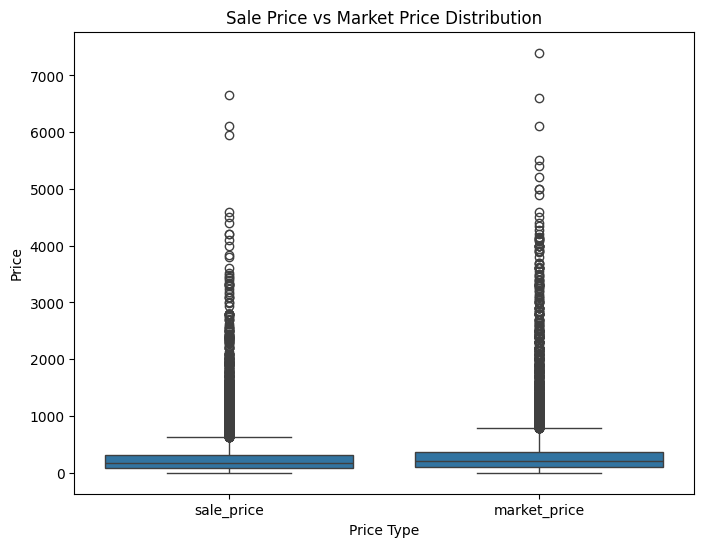

In [110]:
df_melted = df_train[['sale_price', 'market_price']].melt(var_name='Price Type', value_name='Price')
plt.figure(figsize=(8, 6))
sns.boxplot(x='Price Type', y='Price', data=df_melted)
plt.title('Sale Price vs Market Price Distribution')

In [111]:
df_train[['sale_price', 'market_price']].corr()

,sale_price,market_price
sale_price,1.000000,0.954524
market_price,0.954524,1.000000


As I expected, sale price and market price show a very strong positive correlation.
This suggests that both variables capture similar information, which may introduce
multicollinearity in linear models. 

Both price variables exhibit a large number of extreme values.
However, the interquartile range shows that 50% of the products are priced
between approximately 80 and 400, indicating a strong concentration in lower price ranges.

In [112]:
df_train.isnull().sum()

index            0
product          1
category         0
sub_category     0
brand            0
sale_price       0
market_price     0
type             0
rating           0
description     60
dtype: int64

Missing values are mainly present in the `product` and `description` features.
These variables are textual identifiers and free-text descriptions, which are not
considered relevant for the predictive models used in this analysis.
Therefore, their missing values are not expected to affect model performance.

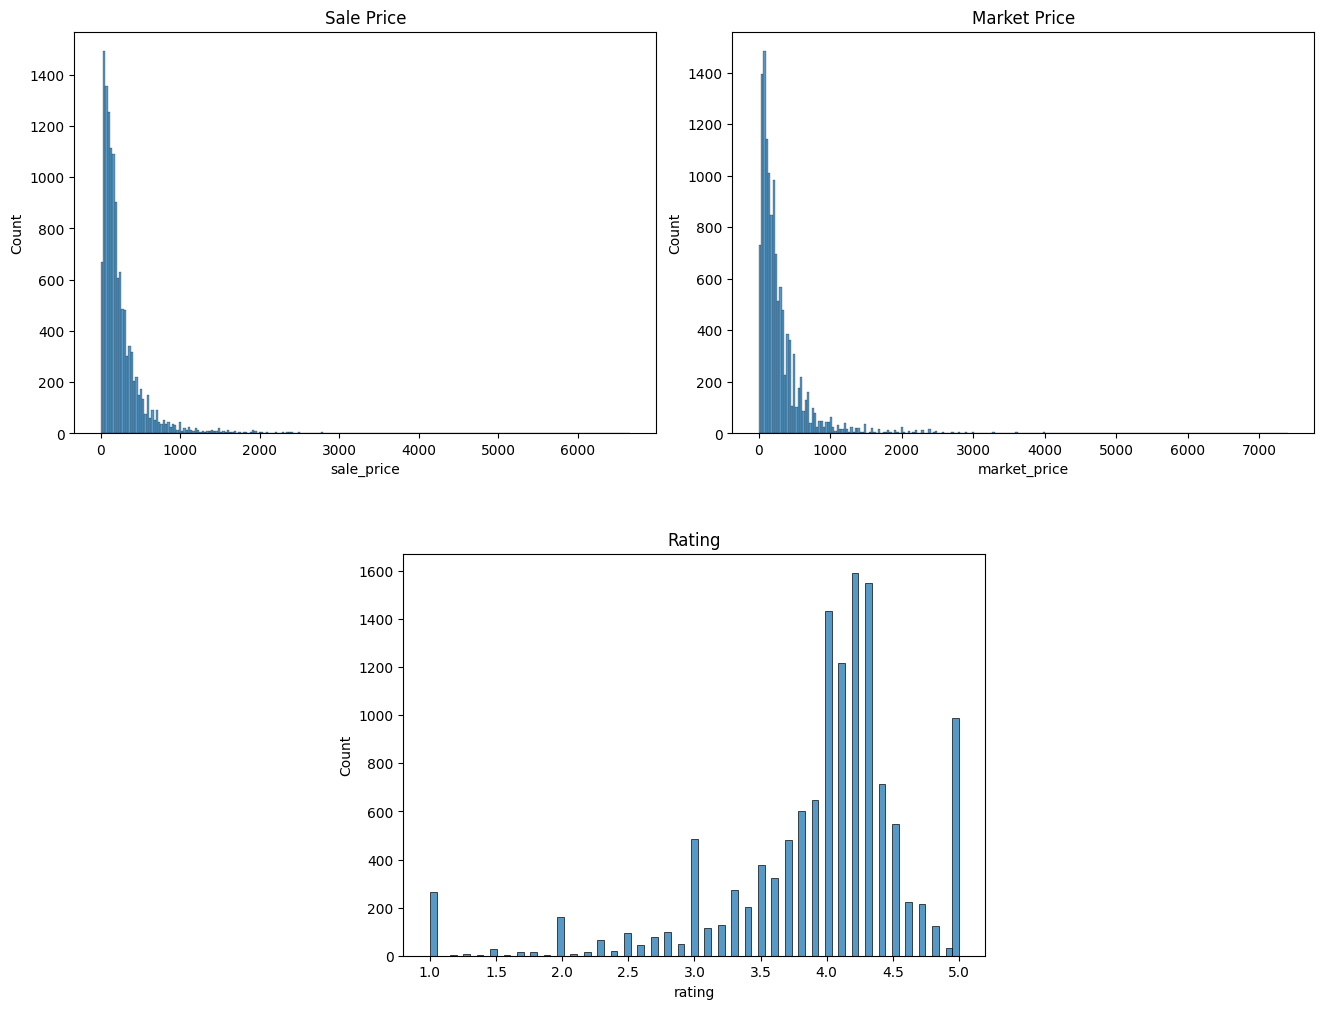

In [113]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0:2])
sns.histplot(df_train['sale_price'], ax=ax1)
ax1.set_title('Sale Price')

ax2 = fig.add_subplot(gs[0, 2:4])
sns.histplot(df_train['market_price'], ax=ax2)
ax2.set_title('Market Price')

ax3 = fig.add_subplot(gs[1, 1:3])
sns.histplot(df_train['rating'], ax=ax3)
ax3.set_title('Rating')

plt.show()

Both sale price and market price show highly right-skewed distributions.
To reduce skewness and stabilize variance, a logarithmic transformation is applied,
followed by standard scaling.


In [114]:
df_train.select_dtypes(include=['object', 'category']).nunique()

product         11806
category            9
sub_category       76
brand            1762
type              353
description     11136
dtype: int64

Some categorical variables exhibit extremely high cardinality.
The `product` variable represents product names, acting mainly as identifiers.
Similarly, `description` consists of long free-text fields with many missing values,
and `type` largely overlaps conceptually with category information.

These features are therefore excluded from the modeling process, as they are unlikely
to provide meaningful predictive signal for product ratings in the chosen models.

In contrast, `category`, `sub_category`, and `brand` are retained, as they may capture
systematic differences in customer perception and product quality.


In [115]:
df_train.groupby('category')['rating'].mean().sort_values()

category
Kitchen, Garden & Pets      3.724552
Bakery, Cakes & Dairy       3.911957
Beauty & Hygiene            3.928207
Cleaning & Household        3.973716
Gourmet & World Food        3.977811
Baby Care                   3.986217
Snacks & Branded Foods      3.989683
Foodgrains, Oil & Masala    4.068782
Beverages                   4.106744
Name: rating, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Gourmet & World Food'),
  Text(1, 0, 'Cleaning & Household'),
  Text(2, 0, 'Snacks & Branded Foods'),
  Text(3, 0, 'Beverages'),
  Text(4, 0, 'Beauty & Hygiene'),
  Text(5, 0, 'Kitchen, Garden & Pets'),
  Text(6, 0, 'Bakery, Cakes & Dairy'),
  Text(7, 0, 'Baby Care'),
  Text(8, 0, 'Foodgrains, Oil & Masala')])

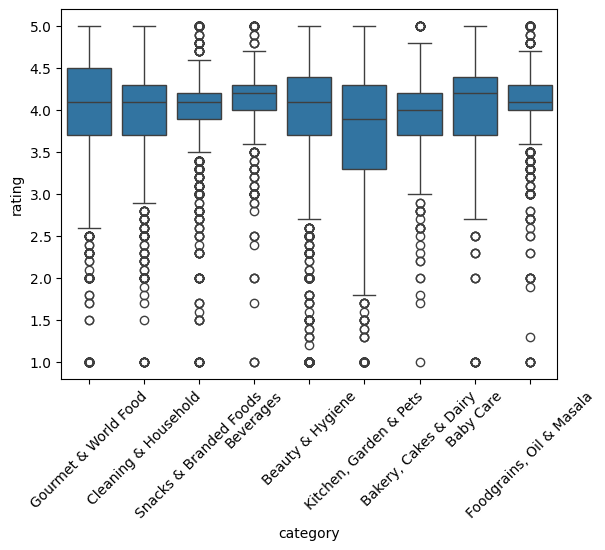

In [116]:
sns.boxplot(x='category', y='rating', data=df_train)
plt.xticks(rotation=45)

Ratings vary moderately across categories.
Although the differences are not large, category-level patterns suggest
that product type may influence customer satisfaction.

<Axes: xlabel='sale_price', ylabel='rating'>

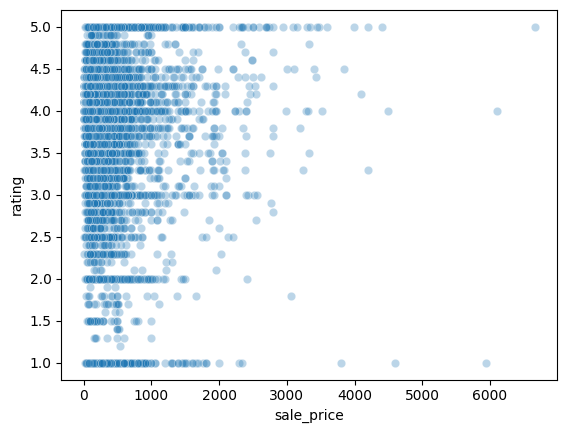

In [117]:
sns.scatterplot(
    x='sale_price',
    y='rating',
    data=df_train,
    alpha=0.3
)


No clear linear relationship is observed between sale price and rating.
While lower-priced products show a wide range of ratings,
higher-priced products are sparse and do not exhibit a consistent trend.


The exploratory analysis shows that numerical price variables are highly skewed
and strongly correlated with each other, motivating logarithmic transformation.

Categorical variables such as category show moderate but consistent differences in ratings,
suggesting they may carry useful predictive information.

In contrast, price-related variables do not show a strong direct relationship
with ratings, indicating that customer satisfaction is likely influenced by multiple factors
rather than price alone.


## 🏗️ Preprocessing

A preprocessing pipeline is constructed to ensure that all transformations are applied
consistently and reproducibly to both the training and test sets.

**Numerical features**
- The numerical variables (`sale_price` and `market_price`) exhibit strong right-skewness.
- To reduce skewness and stabilize variance, a logarithmic transformation is applied.
- Subsequently, the features are standardized to ensure
  comparable scales across variables.

**Categorical features**

Different encoding strategies are employed depending on feature cardinality.

- The `category` variable contains a small number of distinct values and is therefore
  encoded using **one-hot encoding**, avoiding unnecessary complexity while preserving
  interpretability.
- In contrast, `brand` and `sub_category` present very high cardinality.
  To prevent excessive dimensionality and sparsity, these variables are encoded using
  **target encoding**, where each category is replaced by the mean value of the target
  variable.
  A `SafeTargetEncoder` is used to reduce the risk of overfitting through smoothing.

***Pipeline application and data leakage prevention***
- The preprocessing pipeline is fitted exclusively on the training data using
  `fit_transform`, ensuring that target statistics are learned only from the training set so that is no leaking.
- The test data is processed using `transform` only, thereby preventing data leakage.

Finally, the transformed outputs are converted back into pandas DataFrames with
explicitly assigned feature names, improving interpretability and facilitating
subsequent analysis and modeling.


In [118]:
# Define steps for numerical features
numeric_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

# Define steps for categorical features (Target Encoding)
categorical_transformer = SafeTargetEncoder() 

# Define steps for one-hot features
ohe_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['sale_price', 'market_price']),
        ('target_cat', categorical_transformer, ['brand', 'sub_category']),
        ('ohe_cat', ohe_transformer, ['category']) 
    ],
    remainder='drop'
)

X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

num_features = ['sale_price', 'market_price']

target_encoded_features = [
    'brand_te',
    'sub_category_te'
]

ohe_features = preprocessor.named_transformers_['ohe_cat'] \
    .get_feature_names_out(['category'])

feature_names = (
    num_features +
    target_encoded_features +
    list(ohe_features)
)

X_train_preprocessed = pd.DataFrame(
    X_train_preprocessed,
    columns=feature_names,
    index=X_train.index
)

X_test_preprocessed = pd.DataFrame(
    X_test_preprocessed,
    columns=feature_names,
    index=X_test.index
)


## Baseline Model


Before fitting any predictive model, a baseline is established to provide a reference
level of performance.

The baseline model predicts a constant value for all observations, corresponding to
the mean rating observed in the training dataset. This simple approach allows us to
assess whether more complex models offer a meaningful improvement over a naive strategy.

The baseline is evaluated on the test set using standard regression metrics.

In [119]:
y_preds = np.full(shape=df_test['rating'].shape, fill_value=df_train['rating'].mean())
y_test = df_test['rating']

#metrics
mae_base = mean_absolute_error(y_test, y_preds)
mse_base = mean_squared_error(y_test, y_preds)
r2_base = r2_score(y_test, y_preds)
rmse_base = np.sqrt(mse_base)

## Linear Regression model

MODEL PERFORMANCE SUMMARY
    Model Dataset      MSE      MAE     RMSE      R² Score
   LinReg   Train 0.438172 0.443771 0.661946  1.947321e-01
   LinReg    Test 0.525283 0.481040 0.724764  4.663093e-02
BaseModel    Test 0.550976 0.505593 0.742278 -3.229992e-07
------------------------------------------------------------------------------------------


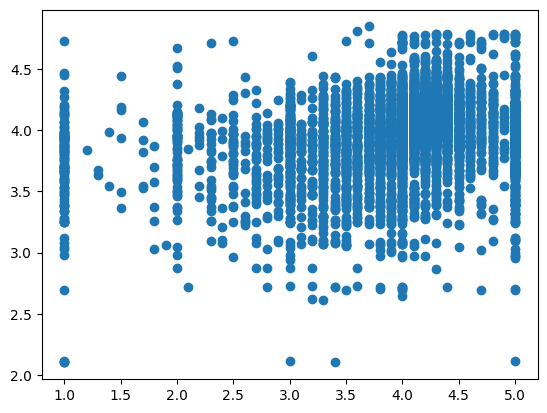

In [120]:
LinReg = LinearRegression()
LinReg.fit(X_train_preprocessed, y_train)

y_pred_train = LinReg.predict(X_train_preprocessed)
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_pred_test = LinReg.predict(X_test_preprocessed)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Model Comparison Summary Table
summary_data = {
    'Model': ['LinReg', 'LinReg','BaseModel'],
    'Dataset': ['Train', 'Test', 'Test'],
    'MSE': [mse_train, mse_test, mse_base],
    'MAE': [mae_train, mae_test, mae_base],
    'RMSE': [np.sqrt(mse_train), np.sqrt(mse_test), rmse_base],
    'R² Score': [r2_train, r2_test, r2_base]
}

summary_df = pd.DataFrame(summary_data)

print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)
print("-"*90)
plt.plot(y_test, y_pred_test, 'o')

<Axes: xlabel='rating', ylabel='Count'>

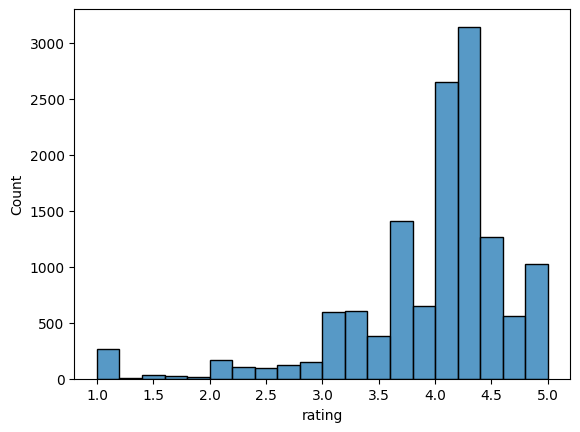

In [121]:
sns.histplot(df_train['rating'], bins=20)

The linear regression model achieves an R² score of approximately 0.08 on the test set,
indicating that only a very small fraction of the variance in product ratings is explained
by the selected features.

As shown in the predicted vs. observed ratings plot, predictions are weakly correlated
with the true values and are heavily concentrated around the mean rating.

The distribution of the target variable reveals a strong imbalance, with most ratings
clustered between 4.0 and 5.0. As a result, the model adopts a conservative strategy,
predicting values within a narrow range (approximately 3.5–4.5) in order to minimize
global error.

This behavior highlights a fundamental limitation of the model: it lacks access to
critical information that drives negative user sentiment, such as product quality,
durability, delivery issues, or customer experience. Consequently, the model is unable
to distinguish truly low-rated products and defaults to predicting average ratings.

These results suggest that price and high-level categorical information alone are
insufficient to accurately predict user ratings, and that a linear modeling approach
is not well suited for this non-linear and highly skewed target distribution.

## GLM model

To extend the linear regression framework and relax the assumption of normally
distributed errors, a Generalized Linear Model (GLM) is estimated.

The same preprocessed feature matrices used in the linear regression analysis are
retained. Since `statsmodels` does not automatically include an intercept term, a
constant column is explicitly added to both the training and test sets. Indexes are
reset to ensure proper alignment between the response variable and the design matrix.

The model is specified using a Gamma distribution with a log link function, which is
appropriate for strictly positive and right-skewed response variables. Model parameters
are estimated using the Iteratively Reweighted Least Squares (IRLS) algorithm.


In [122]:
X_train_glm = sm.add_constant(X_train_preprocessed)
X_train_glm = X_train_glm.reset_index(drop=True)
y_train_glm = y_train.reset_index(drop=True)

X_test_glm = sm.add_constant(X_test_preprocessed)
X_test_glm = X_test_glm.reset_index(drop=True)
y_test_glm = y_test.reset_index(drop=True)

glm_gamma = sm.GLM(
    y_train_glm,
    X_train_glm,
    family=sm.families.Gamma(sm.families.links.log())
)

glm_gamma_results = glm_gamma.fit()


/Users/pcturnes/Documents/Projects/.conda/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [123]:
glm_gamma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 rating   No. Observations:                13250
Model:                            GLM   Df Residuals:                    13237
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                        0.032688
Method:                          IRLS   Log-Likelihood:                -16602.
Date:                Sun, 14 Dec 2025   Deviance:                       603.03
Time:                        22:39:57   Pearson chi2:                     433.
No. Iterations:                    11   Pseudo R-squ. (CS):             0.2020
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -1.1093      0.058    -19.062      0.000      -1.223      -0.995
sale_price                            0.0024      0.009      0.270      0.787      -0.015       0.020
market_price                         -0.0079      0.009     -0.872      0.383      -0.026       0.010
brand_te                              0.5633      0.012     47.582      0.000       0.540       0.586
sub_category_te                       0.0593      0.013      4.615      0.000       0.034       0.084
category_Bakery, Cakes & Dairy        0.0063      0.013      0.475      0.635      -0.020       0.032
category_Beauty & Hygiene             0.0110      0.010      1.064      0.287      -0.009       0.031
category_Beverages                    0.0192      0.013      1.453      0.146      -0.007       0.045
category_Cleaning & Household         0.0343      0.011      3.109      0.002       0.013       0.056
category_Foodgrains, Oil & Masala     0.0031      0.011      0.277      0.781      -0.019       0.025
category_Gourmet & World Food         0.0217      0.011      2.006      0.045       0.000       0.043
category_Kitchen, Garden & Pets       0.0506      0.011      4.451      0.000       0.028       0.073
category_Snacks & Branded Foods       0.0007      0.011      0.063      0.950      -0.021       0.022
=====================================================================================================
"""

In [124]:
y_pred_test_glm = glm_gamma_results.predict(X_test_glm)

In [125]:
mae_glm = mean_absolute_error(y_test_glm, y_pred_test_glm)
mse_glm = mean_squared_error(y_test_glm, y_pred_test_glm)

mae_glm, mse_glm


(0.48696782427980373, 0.5290567324432053)

The GLM results indicate that brand-level information is the dominant driver of product
ratings. The target-encoded brand feature exhibits a large and highly significant effect,
while sub-category information provides an additional but smaller contribution.

In contrast, price-related variables are not statistically significant, suggesting that
price alone does not meaningfully influence user ratings once brand and category effects
are taken into account. Several product categories show modest but statistically
significant deviations from the reference category, although these effects are generally
small.

## Comparison between models and conclusion

This project explored the problem of predicting product ratings using structured
metadata from an online supermarket dataset. Two modeling approaches were evaluated:
a standard Linear Regression model and a Generalized Linear Model (GLM).

A baseline model, which predicts the mean rating of the training set for all observations,
served as a reference point. Both the Linear Regression and the GLM outperform this
baseline, indicating that the available features do contain some predictive signal.
However, the overall explanatory and predictive power of both models remains limited.

The Linear Regression model achieves a very low R² score, suggesting that the assumed
linear relationship between predictors and ratings is insufficient. Diagnostic plots
and the distribution of the target variable reveal that ratings are highly concentrated
between 4 and 5 stars, which leads the model to produce conservative predictions clustered
around the mean. As a result, the model struggles to identify low-rated products and fails
to capture meaningful variation in user sentiment.

The Generalized Linear Model improves upon the linear regression in terms of statistical
appropriateness and interpretability. By using a Gamma distribution with a log link
function, the GLM better accommodates the positive and right-skewed nature of the target
variable. The model highlights brand-level information as the dominant factor influencing
ratings, while price-related variables are found to be statistically insignificant once
brand and category effects are taken into account.

Despite these improvements in model structure and inference, the GLM does not lead to a
substantial gain in predictive performance on the test set. This suggests that the main
limitation is not the modeling technique itself, but rather the information content of
the available features.

Overall, the results indicate that product ratings cannot be reliably predicted using
price and high-level categorical information alone. User ratings are likely driven by
latent factors such as perceived quality, taste, durability, customer service, and
delivery experience, which are not captured in the dataset. Both models therefore provide
useful insights into feature relevance, but only limited predictive capability.


## Suggestions for Future Improvements

Several directions could be explored to improve predictive performance and better capture
the underlying structure of product ratings:

1. **Textual Feature Engineering**  
   Incorporating information from product descriptions using natural language processing
   techniques (e.g., TF-IDF vectors or sentence embeddings) could capture qualitative
   aspects of products that strongly influence user ratings.

2. **Ordinal or Bounded Models**  
   Ratings are bounded between 1 and 5 and inherently ordinal. Models specifically designed
   for ordinal outcomes or bounded continuous variables (such as Beta regression after
   rescaling) may better reflect the nature of the target variable.

3. **Non-linear Models**  
   Tree-based models (e.g., Random Forests, Gradient Boosting, or XGBoost) could capture
   complex non-linear interactions between features that linear models are unable to
   represent.

4. **Regularization and Feature Selection**  
   Penalized regression methods such as Ridge or Lasso could help stabilize coefficient
   estimates and reduce the impact of noise, particularly when working with encoded
   categorical variables.
